# Content-Based Filtering Recommender System

## Table of Contents
1. Loading in Data
2. Scaling Columns
3. One-Hot Encoding Genres
4. NLP Pre-Processing
5. TF-IDF Vectorization
6. Recommendation Function
7. Conclusion

*Please note that essential project background regarding the business question and data sources are in the introduction of the data preparation notebook


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

## 1. Loading in Data

I'll be using two datasets: the reviews dataset created in **section 4.c. of my Data_Preparation Notebook** and the metadata dataset created in **section 4.a.** of said notebook. The former will be for creating the recommender system, and the latter is for receiving user input and returning recommendations.

In [2]:
# Loading in data
# This took about 4 mins
reviews = pd.read_csv('data/gr_reviews_per_book.csv', index_col='book_id')
metadata = pd.read_csv('data/metadata.csv', index_col='book_id')

In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1683101 entries, 1333909 to 22017381
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   average_rating    1683101 non-null  float64
 1   link              1683101 non-null  object 
 2   num_pages         1683101 non-null  float64
 3   ratings_count     1683101 non-null  float64
 4   top_genre         1683101 non-null  object 
 5   reviews_and_desc  1683101 non-null  object 
dtypes: float64(3), object(3)
memory usage: 89.9+ MB


In [6]:
reviews.head()

,average_rating,link,num_pages,ratings_count,top_genre,reviews_and_desc
book_id,,,,,,
1333909,3.23,https://www.goodreads.com/book/show/1333909.Go...,280.0,10.0,fiction,"Anita Diamant's international bestseller ""The ..."
7327624,4.03,https://www.goodreads.com/book/show/7327624-th...,600.0,140.0,"fantasy, paranormal",Omnibus book club edition containing the Ladie...
6066819,3.49,https://www.goodreads.com/book/show/6066819-be...,368.0,51184.0,fiction,Addie Downs and Valerie Adler were eight when ...
287141,4.13,https://www.goodreads.com/book/show/287141.The...,162.0,46.0,"history, historical fiction, biography","Relates in vigorous prose the tale of Aeneas, ..."
6066812,4.22,https://www.goodreads.com/book/show/6066812-al...,216.0,98.0,"fantasy, paranormal","To Kara's astonishment, she discovers that a p..."


## 2. Scaling Columns

Normalization is a preprocessing method that transforms the values of features into a set range. In this case, I will use the MinMaxScaler from sklearn to put feature values into a range from 0 to 1. By standardizing a feature's allowable range of values, I avoid letting features with larger scales impart undue influence on the model's performance. If I didn't scale my features, naturally larger features such as 'num_pages' (which ranges in the hundreds) would be more dominant in the model than smaller features like 'average_rating', which tops out at 5. 

First I need to see if my numerical columns have any outliers/non-normal distributions.

In [6]:
reviews.describe()

,average_rating,num_pages,ratings_count
count,1.683101e+06,1.683101e+06,1.683101e+06
mean,3.876321e+00,2.703536e+02,5.480466e+02
std,4.048658e-01,7.557522e+02,1.316869e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.660000e+00,1.900000e+02,1.000000e+01
50%,3.900000e+00,2.660000e+02,3.100000e+01
75%,4.130000e+00,3.200000e+02,1.100000e+02
max,5.000000e+00,9.450770e+05,4.899965e+06


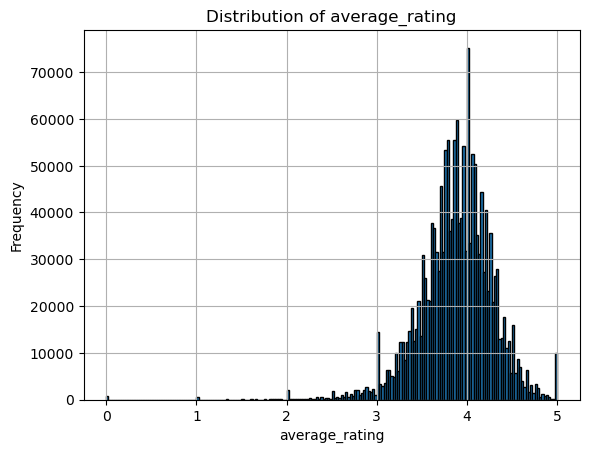

In [23]:
def visualize(df, column):
    plt.hist(df[column], bins=200, edgecolor='black') 
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.grid(True)
    plt.show()

visualize(reviews, 'average_rating')

The distribution of the average ratings is fairly normal. Although it contains a long left tail, there are very few books in that range. In addition, extremely low average book ratings indicate valuable information about these books. Therefore, I will not drop any outliers from the average_rating column.

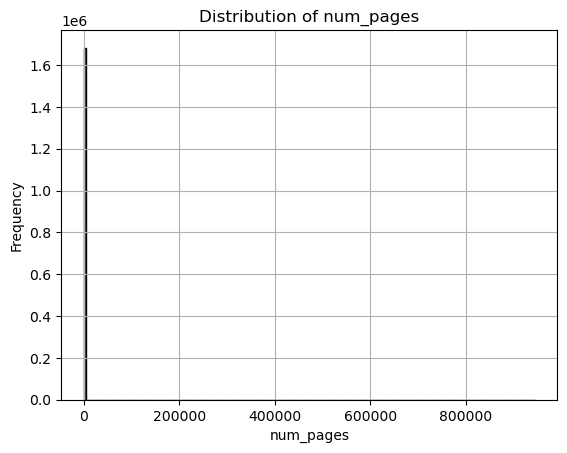

In [24]:
visualize(reviews, 'num_pages')

The number of pages distribution is 
can't drop low pages bc of children's books

In [34]:
reviews['num_pages'].value_counts().sort_index().tail(10)

num_pages
21723.0     1
22950.0     1
28916.0     1
37000.0     1
45000.0     1
52015.0     1
54887.0     1
69473.0     1
82000.0     1
945077.0    1
Name: count, dtype: int64

In [7]:
# Looking at books with an extremely high number of pages
reviews[reviews['num_pages'] > 20000]

,average_rating,link,num_pages,ratings_count,top_genre,reviews_and_desc
book_id,,,,,,
18684543,3.97,https://www.goodreads.com/book/show/18684543-t...,945077.0,378.0,non-fiction,"""Oxford's American editors drew on its 200-mil..."
15781899,4.18,https://www.goodreads.com/book/show/15781899-s...,69473.0,18.0,romance,"Siochain means 'peace' in Gaelic, which is pre..."
11523199,4.39,https://www.goodreads.com/book/show/11523199-t...,21723.0,444.0,fiction,* ALL 15 Novels and ALL illustrated with the o...
20612029,3.79,https://www.goodreads.com/book/show/20612029-p...,52015.0,2.0,young-adult,When Perry ends up in Venice on a European tou...
18193089,4.32,https://www.goodreads.com/book/show/18193089-r...,82000.0,15.0,"fantasy, paranormal",Hell hath no fury like a faery scorned...\nA m...
13520088,4.50,https://www.goodreads.com/book/show/13520088-s...,28916.0,11.0,fiction,"Description copied from Audible.com:\n""...it w..."
2689403,4.50,https://www.goodreads.com/book/show/2689403-ha...,22950.0,33.0,"history, historical fiction, biography",Harvard Classics: Five-Foot Shelf of Books\nKn...
6833141,4.53,https://www.goodreads.com/book/show/6833141,45000.0,17.0,"history, historical fiction, biography","yu`rf yDan bsm ""lmwsw`@ lshmy@ fy trykh lHrwb ..."
13417294,4.00,https://www.goodreads.com/book/show/13417294,21000.0,24.0,non-fiction,lmwsw`@ l`rby@ l`lmy@ hy `ml mwsw`y t`lymy wth...


If you look into the links of these books with extremely high page counts, they mostly seem to be ebooks. Because ebook formatting (thing like font size and spacing) can vary widely, and because some ebooks count pages differently (for example, Kindles use a 'location' system where locations are commonly listed in the thousands instead of following page numbers), these high page count outliers distort the distribution of the data and do not provide meaninful data points. Therefore, I will remove them before scaling.

In [8]:
# Looking at books with no pages
reviews[reviews['num_pages'] == 0]

,average_rating,link,num_pages,ratings_count,top_genre,reviews_and_desc
book_id,,,,,,
11890856,3.89,https://www.goodreads.com/book/show/11890856-p...,0.0,138.0,"fantasy, paranormal",Luce would die for Daniel.\nAnd she has. Over ...
8892235,4.27,https://www.goodreads.com/book/show/8892235-in...,0.0,45.0,"fantasy, paranormal",Just when he thought things couldn't get any w...
9409405,3.83,https://www.goodreads.com/book/show/9409405-on...,0.0,17.0,romance,Livvy thought she lost her chance for a Happil...
24717704,4.39,https://www.goodreads.com/book/show/24717704-t...,0.0,21.0,"fantasy, paranormal",From the Amazon description of the paperback e...
7006335,3.86,https://www.goodreads.com/book/show/7006335-lo...,0.0,20.0,"history, historical fiction, biography",Louisa May Alcottportrays a writer as worthy o...
...,...,...,...,...,...,...
11161131,3.98,https://www.goodreads.com/book/show/11161131-a...,0.0,6.0,non-fiction,"In Autobiography of a Fat Bride, Laurie Notaro..."
21578,3.83,https://www.goodreads.com/book/show/21578.Hugg...,0.0,16.0,"mystery, thriller, crime",Parker presents Spenser with a deceptively dan...
869974,4.24,https://www.goodreads.com/book/show/869974.Com...,0.0,23.0,non-fiction,"In vivid accounts of true cases, surgeon Atul ..."


If you look into the links of each of these books, most seem to be Audio CD's, ebooks, or books that have a page count listed but for some reason weren't scraped properly. Because it doesn't make sense for a book to have 0 pages, I will remove those outliers before scaling. I will not remove low end outliers (such as books with 5 pages) because this would unfairly penalize children's books, which tend to have very few pages in general.

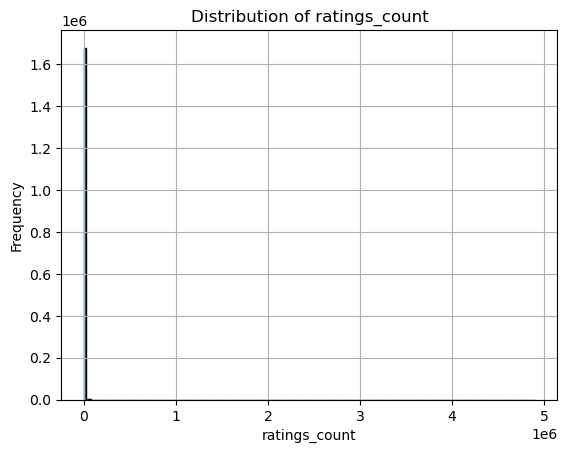

In [28]:
visualize(reviews, 'ratings_count')

In [36]:
reviews['ratings_count'].value_counts().sort_index().tail(10)

ratings_count
2046499.0    1
2078406.0    1
2086945.0    1
2099680.0    1
2429317.0    1
2758812.0    1
3255518.0    1
3941381.0    1
4765497.0    1
4899965.0    1
Name: count, dtype: int64

In [9]:
reviews[reviews['ratings_count'] > 2000000]

,average_rating,link,num_pages,ratings_count,top_genre,reviews_and_desc
book_id,,,,,,
1885,4.25,https://www.goodreads.com/book/show/1885.Pride...,279.0,2078406.0,fiction,"""It is a truth universally acknowledged, that ..."
2767052,4.34,https://www.goodreads.com/book/show/2767052-th...,374.0,4899965.0,young-adult,Winning will make you famous.\nLosing means ce...
41865,3.57,https://www.goodreads.com/book/show/41865.Twil...,498.0,3941381.0,"fantasy, paranormal",About three things I was absolutely positive.\...
5107,3.79,https://www.goodreads.com/book/show/5107.The_C...,277.0,2086945.0,fiction,The hero-narrator of The Catcher in the Ryeis ...
5907,4.25,https://www.goodreads.com/book/show/5907.The_H...,366.0,2099680.0,"fantasy, paranormal",In a hole in the ground there lived a hobbit. ...
4671,3.89,https://www.goodreads.com/book/show/4671.The_G...,180.0,2758812.0,fiction,"THE GREAT GATSBY, F. Scott Fitzgerald's third ..."
5470,4.14,https://www.goodreads.com/book/show/5470.1984,328.0,2023937.0,fiction,"The year 1984 has come and gone, but George Or..."
2657,4.26,https://www.goodreads.com/book/show/2657.To_Ki...,324.0,3255518.0,fiction,The unforgettable novel of a childhood in a sl...
3,4.45,https://www.goodreads.com/book/show/3.Harry_Po...,320.0,4765497.0,"fantasy, paranormal",Harry Potter's life is miserable. His parents ...


Books with exceptionally high ratings counts are exceptionally popular books. Removing these outliers would reduce the quality of my recommender, because it would remove books that have proven themselves very enjoyable. Removing books with no ratings would also unfairly penalize obscure books. Therefore, I will not remove outliers in the ratings_count column.

In [10]:
# Making a copy of the reviews df so I don't save over the original
reviews_scaled = reviews.copy()

# Removing num_pages outliers
reviews_scaled = reviews_scaled[reviews_scaled['num_pages'] != 0]
reviews_scaled[reviews_scaled['num_pages'] == 0]

,average_rating,link,num_pages,ratings_count,top_genre,reviews_and_desc
book_id,,,,,,


Now there are no books with 0 pages in the dataset.

In [11]:
# Removing num_pages upper bound outliers

# Calculate Q1, Q3, and IQR
Q1 = reviews_scaled['num_pages'].quantile(0.25)
Q3 = reviews_scaled['num_pages'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper bound
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
reviews_scaled = reviews_scaled[reviews_scaled['num_pages'] <= upper_bound]

reviews_scaled.describe()

,average_rating,num_pages,ratings_count
count,1.596456e+06,1.596456e+06,1.596456e+06
mean,3.868792e+00,2.486112e+02,5.097262e+02
std,4.069537e-01,1.092399e+02,1.258469e+04
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.650000e+00,1.840000e+02,9.000000e+00
50%,3.890000e+00,2.560000e+02,3.000000e+01
75%,4.120000e+00,3.100000e+02,1.090000e+02
max,5.000000e+00,5.120000e+02,4.899965e+06


The max value of the num_pages column is now much closer to the 75% value. 

In [12]:
# Finally scaling my 3 numeric columns after removing outliers

cols_to_scale = ['average_rating', 'num_pages', 'ratings_count']
scaler = MinMaxScaler()
reviews_scaled[cols_to_scale] = scaler.fit_transform(reviews_scaled[cols_to_scale])

reviews_scaled.head()

,average_rating,link,num_pages,ratings_count,top_genre,reviews_and_desc
book_id,,,,,,
1333909,0.646,https://www.goodreads.com/book/show/1333909.Go...,0.545988,0.000002,fiction,"Anita Diamant's international bestseller ""The ..."
6066819,0.698,https://www.goodreads.com/book/show/6066819-be...,0.718200,0.010446,fiction,Addie Downs and Valerie Adler were eight when ...
287141,0.826,https://www.goodreads.com/book/show/287141.The...,0.315068,0.000009,"history, historical fiction, biography","Relates in vigorous prose the tale of Aeneas, ..."
6066812,0.844,https://www.goodreads.com/book/show/6066812-al...,0.420744,0.000020,"fantasy, paranormal","To Kara's astonishment, she discovers that a p..."
34883016,0.772,https://www.goodreads.com/book/show/34883016-p...,0.495108,0.000001,romance,Secrets. Sometimes keeping them in confidence ...


In [13]:
# Dropping the link column since it's no longer needed for outlier exploration
reviews_scaled.drop(columns=['link'], inplace=True)

## 3. One-Hot Encoding Genres

In [14]:
reviews_scaled_ohe = pd.get_dummies(reviews_scaled, columns=['top_genre'])
reviews_scaled_ohe.head()

,average_rating,num_pages,ratings_count,reviews_and_desc,top_genre_children,"top_genre_comics, graphic","top_genre_fantasy, paranormal",top_genre_fiction,"top_genre_history, historical fiction, biography","top_genre_mystery, thriller, crime",top_genre_non-fiction,top_genre_poetry,top_genre_romance,top_genre_young-adult
book_id,,,,,,,,,,,,,,
1333909,0.646,0.545988,0.000002,"Anita Diamant's international bestseller ""The ...",False,False,False,True,False,False,False,False,False,False
6066819,0.698,0.718200,0.010446,Addie Downs and Valerie Adler were eight when ...,False,False,False,True,False,False,False,False,False,False
287141,0.826,0.315068,0.000009,"Relates in vigorous prose the tale of Aeneas, ...",False,False,False,False,True,False,False,False,False,False
6066812,0.844,0.420744,0.000020,"To Kara's astonishment, she discovers that a p...",False,False,True,False,False,False,False,False,False,False
34883016,0.772,0.495108,0.000001,Secrets. Sometimes keeping them in confidence ...,False,False,False,False,False,False,False,False,True,False


## 4. NLP Processing

The review text data will need to be NLP processed before it can be meaningfully used.  Natural Language Processing (NLP) invovles inputs of a certain type: namely, "tokenized" text. Ideally, a string of lower-case, individual, normalized, semantic words. 

Below we initialize a tokenizer, a stopwords list, and a lemmatizer that we use in a custom function. 

The tokenizer will use a regex pattern to turn all words that are at least 3 letters long into a "token."

The stopwords list will be used to remove words like "is" the "the." These are filler words that have no semantic meaning but are still the majority of most speech. They are not useful for prediction and they dramatically increase the input that a model must process. Therefore, our function iterates through the tokenized text and removes them.

Finally our lemmatizer will get to the meaningful "base" or "lemma" of a word. So it will take "change," "changes," "changed," and "changing" and identify them all as the token "change" instead of 4 separate words. This is essentially the "normalization" of text.

In [15]:
tokenizer = RegexpTokenizer(r"(?u)\w{3,}") # This pattern finds words that are at least 3 letters long
stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def preprocessing(text):
    # Tokenize
    tokens = tokenizer.tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
    
    return ' '.join(tokens)

In [16]:
# Apply the preprocessing function to the 'Text' column
# This took 20 mins
reviews_nlp = reviews_scaled_ohe.copy()
reviews_nlp['tokens'] = reviews_nlp['reviews_and_desc'].apply(preprocessing)
reviews_nlp.head()

,average_rating,num_pages,ratings_count,reviews_and_desc,top_genre_children,"top_genre_comics, graphic","top_genre_fantasy, paranormal",top_genre_fiction,"top_genre_history, historical fiction, biography","top_genre_mystery, thriller, crime",top_genre_non-fiction,top_genre_poetry,top_genre_romance,top_genre_young-adult,tokens
book_id,,,,,,,,,,,,,,,
1333909,0.646,0.545988,0.000002,"Anita Diamant's international bestseller ""The ...",False,False,False,True,False,False,False,False,False,False,anita diamant international bestseller red ten...
6066819,0.698,0.718200,0.010446,Addie Downs and Valerie Adler were eight when ...,False,False,False,True,False,False,False,False,False,False,addie down valerie adler eight first met decid...
287141,0.826,0.315068,0.000009,"Relates in vigorous prose the tale of Aeneas, ...",False,False,False,False,True,False,False,False,False,False,relates vigorous prose tale aeneas legendary a...
6066812,0.844,0.420744,0.000020,"To Kara's astonishment, she discovers that a p...",False,False,True,False,False,False,False,False,False,False,kara astonishment discovers portal opened bedr...
34883016,0.772,0.495108,0.000001,Secrets. Sometimes keeping them in confidence ...,False,False,False,False,False,False,False,False,True,False,secret sometimes keeping confidence good thing...


In [21]:
reviews_nlp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596456 entries, 1333909 to 22017381
Data columns (total 15 columns):
 #   Column                                            Non-Null Count    Dtype  
---  ------                                            --------------    -----  
 0   average_rating                                    1596456 non-null  float64
 1   num_pages                                         1596456 non-null  float64
 2   ratings_count                                     1596456 non-null  float64
 3   reviews_and_desc                                  1596456 non-null  object 
 4   top_genre_children                                1596456 non-null  bool   
 5   top_genre_comics, graphic                         1596456 non-null  bool   
 6   top_genre_fantasy, paranormal                     1596456 non-null  bool   
 7   top_genre_fiction                                 1596456 non-null  bool   
 8   top_genre_history, historical fiction, biography  1596456 non-null  bo

In [22]:
reviews_nlp.drop(columns=['reviews_and_desc'], inplace=True)

In [17]:
# The nlp procesing took 20 mins, so I want to save off its results so that
# I don't have to run it again if I close the notebook or it crasehs
reviews_nlp.to_csv('data/reviews_nlp.csv')

## 5. TF-IDF Vectorization

In [3]:
# Un comment this if you want to run the notebook from this point on. 
# Metadata will need to be loaded in also
# reviews_nlp = pd.read_csv('data/reviews_nlp.csv', index_col='book_id')

In [10]:
reviews_nlp.dropna(subset=['tokens'], inplace=True)

In [11]:
tfidf = TfidfVectorizer(max_features=250)
dtm = tfidf.fit_transform(reviews_nlp['tokens'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names_out(), index=reviews_nlp.index)
dtm.head()

,action,actually,adventure,age,almost,along,also,always,amazing,american,...,woman,word,work,world,would,writing,written,year,yet,young
book_id,,,,,,,,,,,,,,,,,,,,,
1333909,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.269968,0.0,0.0,0.338018,0.0,0.0,0.0,0.000000,0.000000,0.0
6066819,0.0,0.0,0.23184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.176460,0.0,0.0,0.000000,0.0,0.0,0.0,0.300253,0.000000,0.0
287141,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.288888,0.000000,0.0
6066812,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.096833,0.000000,0.0
34883016,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.148104,0.0,0.0,0.000000,0.0,0.0,0.0,0.126002,0.180406,0.0


In [26]:
dtm.to_parquet('data/dtm.parquet')

In [12]:
df = dtm.merge(reviews_nlp, left_index=True, right_index=True)
df.drop(columns=['tokens'], inplace=True)
df.head()

,action,actually,adventure,age,almost,along,also,always,amazing,american,...,top_genre_children,"top_genre_comics, graphic","top_genre_fantasy, paranormal",top_genre_fiction,"top_genre_history, historical fiction, biography","top_genre_mystery, thriller, crime",top_genre_non-fiction,top_genre_poetry,top_genre_romance,top_genre_young-adult
book_id,,,,,,,,,,,,,,,,,,,,,
1333909,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
6066819,0.0,0.0,0.23184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
287141,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
6066812,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
34883016,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596456 entries, 1333909 to 22017381
Columns: 263 entries, action to top_genre_young-adult
dtypes: bool(10), float64(253)
memory usage: 3.1 GB


In [13]:
df.to_csv('data/df.csv')

## 6. Recommendation Function

In [15]:
# Changing the metdata column titles to be more user-friendly
metadata.rename(columns={'average_rating': 'Average Rating', 'similar_books': 'Similar Books', 
                         'description':'Summary', 'link':'Link', 'num_pages':'Number of Pages', 
                         'ratings_count': 'Number of Ratings', 'title':'Title', 'top_genre':'Genre',
                        'authors_names': 'Authors'}, inplace=True)

In [53]:
# User input should be a book title. I used "Good Harbor" as an example
title_input = input('Book Title: ')

# Finding that book in the metadata dataset (which contains book titles) then returning its index (book_id)
book = metadata.index[metadata['Title'] == title_input][:1]
book

Index([1333909], dtype='int64', name='book_id')

In [54]:
# Finding that book in the model's dataframe df so we can get similarity scores for only this book
book_vector = np.array(df.loc[book])
book_vector = book_vector.reshape(1, -1)
book_vector

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.11521279117202536, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.2688606138852036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.3177968516536494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.14530601163987883, 0.0, 0.16083296459463473,
        0.0, 0.17517650080289668, 0.17906484803891942, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16928914358302927,
        0.0, 0.1913909667838505, 0.13612427555136605, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.11854257047067093, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.1655995200564535, 

In [55]:
# Calculate the cosine similarity matrix between the book vector and all other book vectors
cos_sim = cosine_similarity(df, book_vector)
# Make the matrix into a dataframe
cos_sim_df = pd.DataFrame(data=cos_sim, index=df.index)
cos_sim_df.head()

,0
book_id,
1333909,1.000000
6066819,0.721751
287141,0.256749
6066812,0.323127
34883016,0.385975


In [61]:
# Ask the user for input on how many similar books they want to see
num_books = int(input('How many similar books would you like to see? '))

# Sort the similarity scores in descending order
sorted_scores = cos_sim_df[0].sort_values(ascending=False)

In [64]:
# The most similar book will be the first one because
# the similarity score will be 1 (the book is most similar to itself)
# so we want to skip the first book
most_similar_books = sorted_scores.index.values[sorted_scores.index != book][1:num_books+1]
most_similar_books 

array([ 4352215,  2189204, 29044469, 20336442, 29890955])

In [66]:
# Get the metadata for the most similar books
similar_books_metadata = metadata.loc[most_similar_books]
similar_books_metadata 

,isbn,Average Rating,Similar Books,Summary,Link,Number of Pages,Number of Ratings,Title,Genre,Authors
book_id,,,,,,,,,,
4352215,0613274237,3.36,"['The Treasure Hunt: A Little Bill Book', 'Riv...",In her remarkable debut novel . . . Manette An...,https://www.goodreads.com/book/show/4352215-vi...,NaN,12.0,Vinegar Hill,fiction,['A. Manette Ansay']
2189204,0395856973,3.53,"['The Selling of the President', 'Hummingbird ...",This is a novel about the will to power of one...,https://www.goodreads.com/book/show/2189204.Ec...,328.0,15.0,Echo House,fiction,['Ward Just']
29044469,1771620871,4.35,"['Memory Serves', 'Simple Recipes', 'Confined ...",Jennifer Manuel skilfully depicts the lonely w...,https://www.goodreads.com/book/show/29044469-t...,288.0,155.0,The Heaviness of Things That Float,fiction,['Jennifer Manuel']
20336442,NaN,3.48,[],Robyn Merrill hopes that starting a new life i...,https://www.goodreads.com/book/show/20336442-t...,NaN,9.0,The House On Swiss Avenue,fiction,['Irene Sandell']
29890955,0888015917,3.80,[],"Duty, desire, love, and purpose. Who we want t...",https://www.goodreads.com/book/show/29890955-t...,184.0,9.0,The Waiting Place,fiction,['Sharron Arksey']


In [18]:
# Now that we know that code works, making it all into one function

def get_similar_books():
    # User input should be a book title. I used "Good Harbor" as an example
    title_input = input('Book Title: ')

    # Finding that book in the metadata dataset (which contains book titles) then returning its index (book_id)
    book = metadata.index[metadata['Title'] == title_input][:1] 
    
    # Finding that book in the model's dataframe df so we can get similarity scores for only this book
    book_vector = np.array(df.loc[book])
    book_vector = book_vector.reshape(1, -1)
    
    # Calculate the cosine similarity matrix between the book vector and all other book vectors
    cos_sim = cosine_similarity(df, book_vector)
    
    # Make the matrix into a dataframe
    cos_sim_df = pd.DataFrame(data=cos_sim, index=df.index) 
    
    # Sort the similarity scores in descending order
    sorted_scores = cos_sim_df[0].sort_values(ascending=False)
    
    # Asking the user how many book recommendations they want
    num_books = int(input('How many similar books would you like to see? '))

    # Getting the most similar books
    most_similar_books = sorted_scores.index.values[sorted_scores.index][1:num_books+1]

    # Get the metadata for the most similar books
    similar_books_metadata = metadata.loc[most_similar_books]

    return similar_books_metadata

get_similar_books()


: 

In [16]:
# def get_similar_books():
#     # User input should be a book title. I used "Good Harbor" as an example
#     title_input = input('Book Title: ')

#     # Finding that book in the metadata dataset (which contains book titles) then returning its index (book_id)
#     book = metadata[metadata['Title'] == title_input].index[:1] 
    
#     # Finding that book in the model's dataframe df so we can get similarity scores for only this book
#     book_vector = np.array(df.loc[book])
#     book_vector = book_vector.reshape(1, -1)
    
#     # Calculate the cosine similarity matrix between the book vector and all other book vectors
#     cos_sim = cosine_similarity(df, book_vector)
    
#     # Make the matrix into a dataframe
#     cos_sim_df = pd.DataFrame(data=cos_sim, index=df.index) 
    
#     # Sort the similarity scores in descending order
#     sorted_scores = cos_sim_df[0].sort_values(ascending=False)
    
#     # Asking the user how many book recommendations they want
#     num_books = int(input('How many similar books would you like to see? '))

#     # Get the index value from the book variable
#     book_index = book[0]

#     # Getting the most similar books
#     most_similar_books = sorted_scores.index.values[sorted_scores.index != book_index][:num_books]

#     # Filter out the book with the same title as the input
#     similar_books_metadata = metadata.loc[most_similar_books][metadata['Title'] != title_input]

#     return similar_books_metadata

# get_similar_books()


ValueError: could not convert string to float: 'Anita Diamant\'s international bestseller "The Red Tent" brilliantly re-created the ancient world of womanhood. Diamant brings her remarkable storytelling skills to "Good Harbor" -- offering insight to the precarious balance of marriage and career, motherhood and friendship in the world of modern women. The seaside town of Gloucester, Massachusetts is a place where the smell of the ocean lingers in the air and the rocky coast glistens in the Atlantic sunshine. When longtime Gloucester-resident Kathleen Levine is diagnosed with breast cancer, her life is thrown into turmoil. Frightened and burdened by secrets, she meets Joyce Tabachnik -- a freelance writer with literary aspirations -- and a once-in-a-lifetime friendship is born. Joyce has just bought a small house in Gloucester, where she hopes to write as well as vacation with her family. Like Kathleen, Joyce is at a fragile place in her life.\nA mutual love for books, humor, and the beauty of the natural world brings the two women together. They share their personal histories, and help each other to confront scars left by old emotional wounds.\nWith her own trademark wisdom and humor, Diamant considers the nature, strength, and necessity of adult female friendship. "Good Harbor" examines the tragedy of loss, the insidious nature of family secrets, as well as the redemptive power of friendship.'

In [78]:
get_similar_books()

ValueError: Lengths must match to compare